在鑑定碼嵌入方法中，t-bits大小的鑑定碼會被嵌入到WxH大小的Demosaicked圖像中。實際上，各個嵌入碼ac會被遷入到Demosaicked的各個顏色像素當中。假設顏色像素cp = (r, g, b)，嵌入鑑定碼ac到cp，首先要計算總值sum = r+g+b，然後將sum轉換為t-bit大小的值pv = sum mod 2^t，如果pv = ac，則不需改變cp，否則我們需要矯正cp中的值，使得pv = ac。

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# image = np.array(
#     [
#         [[222, 133, 121],
#         [222, 133, 121],
#         [226, 133, 121],
#         [226, 133, 121],
#         [222, 125, 113]],

#        [[222, 133, 121],
#         [222,  93, 121],
#         [226, 137, 121],
#         [226, 133, 121],
#         [222, 133, 113]],

#        [[222, 133, 121],
#         [222, 133, 121],
#         [226, 133, 121],
#         [226, 133, 121],
#         [222, 125, 113]],

#        [[222, 133, 121],
#         [222,  93, 121],
#         [226, 137, 121],
#         [226, 133, 121],
#         [222, 133, 113]],

#        [[222, 133, 121],
#         [222, 133, 121],
#         [226, 133, 109],
#         [226, 133, 109],
#         [222, 125, 113]]
#     ]
# )
image = np.array(
    [
        [[222, 133, 121],
        [222, 133, 121],
        [226, 133, 121],
        [226, 133, 121]],

       [[222, 133, 121],
        [222,  93, 121],
        [226, 137, 121],
        [226, 133, 121]],

       [[222, 133, 121],
        [222, 133, 121],
        [226, 133, 121],
        [226, 133, 121]],

       [[222, 133, 121],
        [222,  93, 121],
        [226, 137, 121],
        [226, 133, 121]]]
)
height, width = image.shape[:2]
seed = 7
t = 4

# H: height
# W: width
# seed: random seed
# t: user requirement for authentication code
def generate_ac(H, W, seed, t):
    random.seed(seed)
    ac = np.zeros((H, W), dtype=np.uint8)
    for i in range(H):
        for j in range(W):
            ac[i][j] = random.randint(0, 2**t-1)
    return ac

In [3]:
def authentication_code(pixel, t):
    sum = pixel.sum()
    pv = sum % 2**t
    return pv
    # return pv

def authentication_code_pixel(pixel, t):
    sum = pixel.sum()
    pv = sum % 2**t
    return pv
    # return pv

def authentication_code_image(image, t):
    return np.array(image).sum(axis=2) % (2**t)

## Example for a array of pixels

$ sum = r + g + b $
<br/>
$ pv = sum mod 2^t $
<br/>
$ dif = pv - ac $
<br/>
<!-- $$ 
dif = 
\begin{cases} 
dif-2^t, & \mbox{if}n\mbox{dif > 2^t} \\
dif+2^t, & \mbox{if}n\mbox{dif < -2^t}
\end{cases}
$$
<br/> -->
$$
if dif > 2^{t-1}
$$

In [4]:
# cp = authentication_code(image[0, 0], t)
acs = generate_ac(height, width, seed, t)
print("acs", acs)
pvs = [[authentication_code(image[i, j], t) for j in range(0, width)] for i in range(0, height)]
print("pvs", pvs)
dif = pvs - acs
dif[dif > 2**(t-1)] -= 2**t
dif[dif < -(2**(t-1))] += 2**t
print("dif", dif)
dis_p1 = np.array(dif/2, np.int8)
dis_p2 = dif-dis_p1
print("dis_p1", dis_p1)
print("dis_p2", dis_p2)


acs [[10  4 12  1]
 [ 2  3 11  1]
 [ 6  1  2 13]
 [13  2  7  2]]
pvs [[12, 12, 0, 0], [12, 4, 4, 0], [12, 12, 0, 0], [12, 4, 4, 0]]
dif [[ 2  8  4 -1]
 [-6  1 -7 -1]
 [ 6 -5 -2  3]
 [-1  2 -3 -2]]
dis_p1 [[ 1  4  2  0]
 [-3  0 -3  0]
 [ 3 -2 -1  1]
 [ 0  1 -1 -1]]
dis_p2 [[ 1  4  2 -1]
 [-3  1 -4 -1]
 [ 3 -3 -1  2]
 [-1  1 -2 -1]]


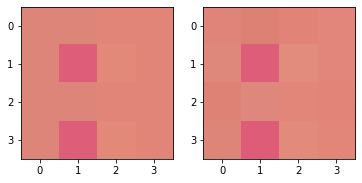

In [5]:
new_image = np.copy(image)
new_image[:, :, 1] -= dis_p1
new_image[:, :, 2] -= dis_p2

fig, axs = plt.subplots(1, 2)
axs[0].imshow(image)
axs[1].imshow(new_image)

In [6]:
image_pvs = new_image.sum(axis=2) % 2**t
print("acs", acs[0:5, 0:5])
print("image_pvs", image_pvs[0:5, 0:5])

acs [[10  4 12  1]
 [ 2  3 11  1]
 [ 6  1  2 13]
 [13  2  7  2]]
image_pvs [[10  4 12  1]
 [ 2  3 11  1]
 [ 6  1  2 13]
 [13  2  7  2]]


In [7]:
new_image.sum() % 2**t

10

## Example for a single pixel

In [8]:
cp = np.array([193, 194, 203])
ac = 0

cp_sum = cp.sum()
pv = cp_sum % 2**t
dif = pv - ac
if dif > 2**(t-1):
    dif -= 2**t
elif dif < -(2**(t-1)):
    dif += 2**t

dis_p1 = int(dif/2)
dis_p2 = dif-dis_p1
dif, dis_p1, dis_p2

cp[1] -= dis_p1
cp[2] -= dis_p2
cp.sum() % 2**t

pv, dif, dis_p1, dis_p2

(14, -2, -1, -1)

## Permute

In [9]:
## ravel -> shuffle -> reshape(https://moonbooks.org/Articles/How-to-randomly-shuffle-an-array-in-python-using-numpy/)
## numpy.random.permutation(https://numpy.org/doc/stable/reference/random/generated/numpy.random.permutation.html)
## shuffle_2D_matrix.py(https://gist.github.com/AidySun/bb2b90a993d74400ababb8c8bdbf1d40)

def permuted_1(perm, height, width, seed):
    # print("Origin", perm)
    _perm = perm.ravel()
    random.seed(seed)
    random.shuffle(_perm)
    # print("shuffle", perm)
    return perm.reshape(height, width)

def permuted_2(perm, height, width, seed):
    # print("Origin", perm)
    _perm = perm.ravel()
    np.random.seed(seed)
    permuted = np.random.permutation(_perm)
    # print("permutation", permuted)
    return permuted.reshape(height, width)

def permuted_3(perm, height, width, seed):
    np.random.seed(seed)
    _perm = perm.ravel().reshape((1,height*width))
    permutation = list(np.random.permutation(height*width))
    return _perm[:, permutation].reshape(height, width)

n = 4
PK = 7
perm = np.arange(n**2)+1
permuting1 = permuted_1(perm, n, n, PK)
perm = np.arange(n**2)+1
permuting2 = permuted_2(perm, n, n, PK)
perm = np.arange(n**2)+1
permuting3 = permuted_3(perm, n, n, PK)

permuting1, permuting2, permuting3

(array([[ 4, 15,  8, 10],
        [14, 12,  5,  6],
        [13,  9,  2,  1],
        [16,  7,  3, 11]]),
 array([[ 9,  6, 11,  3],
        [13,  1,  2, 15],
        [14,  8, 12,  4],
        [ 7, 10,  5, 16]]),
 array([[ 9,  6, 11,  3],
        [13,  1,  2, 15],
        [14,  8, 12,  4],
        [ 7, 10,  5, 16]]))

In [10]:
perm1 = np.arange(n**2)+1
permuting1 = permuted_3(perm1, n, n, PK)

perm2 = np.arange(n**2)+2
permuting2 = permuted_3(perm2, n, n, PK)

permuting1, permuting2

(array([[ 9,  6, 11,  3],
        [13,  1,  2, 15],
        [14,  8, 12,  4],
        [ 7, 10,  5, 16]]),
 array([[10,  7, 12,  4],
        [14,  2,  3, 16],
        [15,  9, 13,  5],
        [ 8, 11,  6, 17]]))

In [11]:
def getLowOrder(X, bits):
    return np.array(X) & ((1 << bits) - 1)

def setLowOrder(X, bits, value):
    return (np.array(X) & ~((1 << bits) - 1)) | value

getLowOrder([119, 116], 2)

array([3, 0], dtype=int32)

In [12]:
OriginSampledComponents = np.array(
    [
        [119, 116, 117, 117],
        [120, 119, 119, 123],
        [118, 115, 117, 120],
        [118, 120, 118, 115]
    ]
)

LowOrder2Bits_Components = getLowOrder(OriginSampledComponents, 2)
PK = 7
permuted_LowOrder2Bits_Components = permuted_1(
    LowOrder2Bits_Components, 
    LowOrder2Bits_Components.shape[0], 
    LowOrder2Bits_Components.shape[1], 
    PK
)
print("Origin Components", OriginSampledComponents)
print("Low-Order 2 bits Origin Components", LowOrder2Bits_Components)
print("Permuted Low-Order 2 bits for Origin Components", permuted_LowOrder2Bits_Components)

Origin Components [[119 116 117 117]
 [120 119 119 123]
 [118 115 117 120]
 [118 120 118 115]]
Low-Order 2 bits Origin Components [[1 2 3 3]
 [0 0 0 3]
 [2 2 0 3]
 [3 3 1 1]]
Permuted Low-Order 2 bits for Origin Components [[1 2 3 3]
 [0 0 0 3]
 [2 2 0 3]
 [3 3 1 1]]


In [13]:
permuted_Components = setLowOrder(OriginSampledComponents, 2, permuted_LowOrder2Bits_Components)
permuted_Components, getLowOrder(permuted_Components, 2)

(array([[117, 118, 119, 119],
        [120, 116, 116, 123],
        [118, 114, 116, 123],
        [119, 123, 117, 113]], dtype=int32),
 array([[1, 2, 3, 3],
        [0, 0, 0, 3],
        [2, 2, 0, 3],
        [3, 3, 1, 1]], dtype=int32))

In [14]:
def permutedLowOrder(arr, height, width, permutation_key, ld):
    LowOrderBits_Components = getLowOrder(arr, ld)
    permuted_LowOrder2Bits_Components = permuted_2(
        LowOrderBits_Components, 
        height, 
        width, 
        permutation_key
    )
    return setLowOrder(arr, ld, permuted_LowOrder2Bits_Components)

## Demo for Lenna

In [66]:
import imageio

from libs.util import readImg, psnr
from libs.CFA import rgb2cfa, demosaicked

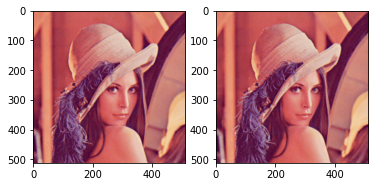

working_image is Demosaicked:  True


In [67]:
image = readImg("./Dataset/lena_color.gif")
cfa = rgb2cfa(image)
Demosaicked = demosaicked(cfa)
Demosaicked = Demosaicked

working_image = Demosaicked.astype(np.int16)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(Demosaicked)
axs[1].imshow(working_image)
plt.show()

print("working_image is Demosaicked: ", np.array_equal(Demosaicked, working_image))

In [69]:
H, W = working_image.shape[:2]
Sd = 7
t = 1
PK = 7

In [70]:
## Test for authentication both the two function

# pvs = np.array([[authentication_code(working_image[i, j], t) for j in range(0, W)] for i in range(0, H)])
# test_pvs = authentication_code_image(working_image, t)

# print("pvs", pvs.shape, pvs[0:5, 0:5])
# print("test_pvs", test_pvs.shape, test_pvs[0:5, 0:5])

# np.array_equal(pvs, test_pvs)

In [71]:
acs = generate_ac(H, W, seed, t)
print("acs", acs.shape, acs[0:5, 0:5])
pvs = authentication_code_image(Demosaicked, t)
dif = pvs - acs
dif[dif > 2**(t-1)] -= 2**t
dif[dif < -(2**(t-1))] += 2**t
dis_p1 = np.array(dif/2, np.int16)
dis_p2 = dif-dis_p1

working_image[:, :, 1] -= dis_p1
working_image[:, :, 2] -= dis_p2

acs (512, 512) [[1 0 1 0 0]
 [1 0 1 1 0]
 [1 1 0 1 1]
 [0 0 0 1 1]
 [0 0 1 1 0]]


In [72]:
embedding_pvs = authentication_code_image(working_image, t)
print("check embedding pvs is equal the acs or not: ", np.array_equal(acs, embedding_pvs))

print("embedding_pvs", embedding_pvs.shape, embedding_pvs[0:5, 0:5])

check embedding pvs is equal the acs or not:  True
embedding_pvs (512, 512) [[1 0 1 0 0]
 [1 0 1 1 0]
 [1 1 0 1 1]
 [0 0 0 1 1]
 [0 0 1 1 0]]


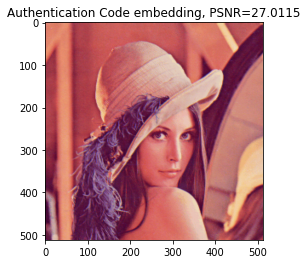

In [73]:
plt.title("Authentication Code embedding, PSNR={:.4f}".format(psnr(image, working_image.astype('uint8'))))
plt.imshow(working_image)
plt.show()
embedded_image = np.copy(working_image)

In [74]:
working_image[:, :, 0] = permutedLowOrder(embedded_image[:, :, 0], height=H, width=W, permutation_key=PK, ld=t)
print("[0:5, 0:5, 0]")
print("embedded_image\n", embedded_image[0:5, 0:5, 0])
print("working_image\n", working_image[0:5, 0:5, 0])
working_image[:, :, 1] = permutedLowOrder(embedded_image[:, :, 1], height=H, width=W, permutation_key=PK, ld=t)
print("[0:5, 0:5, 1]")
print("embedded_image\n", embedded_image[0:5, 0:5, 1])
print("working_image\n", working_image[0:5, 0:5, 1])
working_image[:, :, 2] = permutedLowOrder(embedded_image[:, :, 2], height=H, width=W, permutation_key=PK, ld=t)
print("[0:5, 0:5, 2]")
print("embedded_image\n", embedded_image[0:5, 0:5, 2])
print("working_image\n", working_image[0:5, 0:5, 2])

[0:5, 0:5, 0]
embedded_image
 [[222 222 226 226 222]
 [222 222 226 226 222]
 [222 222 226 226 222]
 [222 222 226 226 222]
 [222 222 226 226 222]]
working_image
 [[223 223 226 226 223]
 [222 223 227 226 222]
 [223 222 227 227 222]
 [223 222 226 226 222]
 [222 222 226 226 223]]
[0:5, 0:5, 1]
embedded_image
 [[135 133 135 133 125]
 [135  93 139 135 133]
 [135 135 133 135 127]
 [133  93 137 135 135]
 [133 133 135 135 125]]
working_image
 [[134 132 134 132 124]
 [134  92 138 135 132]
 [134 134 132 134 127]
 [132  93 136 134 134]
 [132 133 135 134 124]]
[0:5, 0:5, 2]
embedded_image
 [[122 121 122 121 113]
 [122 121 122 122 113]
 [122 122 121 122 114]
 [121 121 121 122 114]
 [121 121 110 110 113]]
working_image
 [[122 121 122 120 113]
 [122 121 123 123 112]
 [122 123 120 122 115]
 [121 121 121 122 115]
 [121 120 110 110 113]]


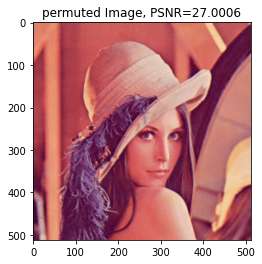

In [75]:
plt.title("permuted Image, PSNR={:.4f}".format(psnr(image, working_image.astype('uint8'))))
plt.imshow(Demosaicked)

In [76]:
permuted_acs = permuted_2(acs, H, W, PK)
permuted_acs[0:5, 0:5]

array([[1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [1, 1, 1, 1, 0],
       [0, 0, 1, 0, 1],
       [1, 1, 1, 0, 0]], dtype=uint8)

In [77]:
working_image_ac = authentication_code_image(working_image, t)
working_image_ac[0:5, 0:5]

array([[1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [1, 1, 1, 1, 0],
       [0, 0, 1, 0, 1],
       [1, 1, 1, 0, 0]], dtype=int32)

In [78]:
def ImageUnTamperArea(image, tampered):
    _image = np.copy(image)
    _image[:, :, 0]*=tampered
    _image[:, :, 1]*=tampered
    _image[:, :, 2]*=tampered
    return _image

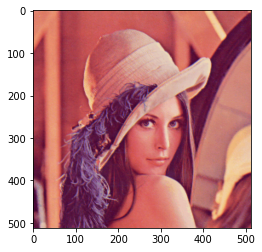

In [79]:
tampered = (permuted_acs == working_image_ac)
untampered_image = ImageUnTamperArea(working_image, tampered)
plt.imshow(untampered_image)

In [80]:
permuted_embedding_image = working_image.astype(np.uint8)

In [81]:
imageio.imwrite(r"./lena_Demosaicked_embedding_t={}.png".format(t), permuted_embedding_image)

In [82]:
save_img = imageio.imread("./lena_Demosaicked_embedding.png")

In [63]:
save_img[0:10, 0:10]

Array([[[209, 135, 112],
        [217, 133, 116],
        [226, 159, 130],
        [234, 137, 143],
        [221, 142, 121],
        [213, 135, 122],
        [222, 138, 125],
        [222, 128, 119],
        [225, 148, 140],
        [225, 137, 132]],

       [[214, 129, 137],
        [209,  80, 115],
        [233, 150, 133],
        [230, 154, 129],
        [222, 143, 122],
        [209, 134, 119],
        [209, 138, 141],
        [218, 130, 129],
        [234, 150, 130],
        [234, 155, 131]],

       [[217, 131, 140],
        [210, 140, 124],
        [229, 147, 131],
        [233, 146, 142],
        [210, 117, 121],
        [213, 112, 120],
        [218, 131, 135],
        [222, 139, 134],
        [237, 159, 142],
        [224, 133, 117]],

       [[209, 143, 115],
        [210,  83, 123],
        [234, 144, 132],
        [226, 148, 143],
        [210, 154, 124],
        [210, 149, 117],
        [218, 141, 117],
        [222, 131, 135],
        [234, 158, 130],
        [238, 151, 

In [64]:
working_image[0:10, 0:10]

array([[[221, 136, 125],
        [221, 136, 123],
        [226, 137, 125],
        [226, 134, 120],
        [221, 124, 112],
        [221, 124, 112],
        [222, 136, 127],
        [222, 132, 123],
        [225, 136, 123],
        [225, 135, 123]],

       [[222, 139, 127],
        [221,  92, 120],
        [225, 140, 124],
        [226, 138, 124],
        [222, 134, 113],
        [221, 139, 115],
        [221, 139, 126],
        [222, 129, 124],
        [226, 143, 127],
        [226, 138, 126]],

       [[221, 136, 125],
        [222, 136, 124],
        [225, 139, 122],
        [225, 139, 126],
        [222, 129, 117],
        [221, 131, 119],
        [222, 136, 127],
        [222, 137, 124],
        [225, 139, 122],
        [224, 135, 123]],

       [[221, 136, 123],
        [222,  93, 121],
        [226, 140, 121],
        [226, 138, 125],
        [222, 137, 119],
        [222, 137, 116],
        [222, 137, 124],
        [222, 128, 124],
        [226, 140, 124],
        [226, 136, 

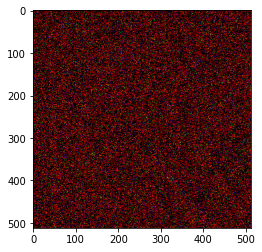

In [65]:
tampered = (save_img == working_image)
tampered[0, 0, 0]
plt.imshow(tampered*255)